In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0029.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0195.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0051.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0074.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0142.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0149.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0121.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0194.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0003.png
/kaggl

In [2]:
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision import models, datasets
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image

Смотрим на какие папки разбивается корневая папка

In [3]:
os.listdir('../input/leapgestrecog/leapGestRecog')

['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']

In [4]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 1.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

Смотрим какие жесты есть в датасете

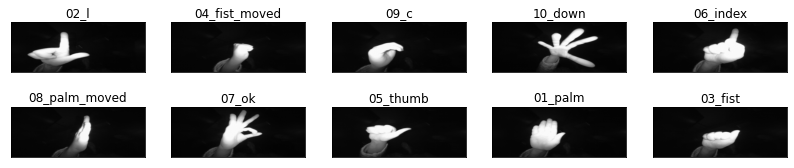

In [5]:
dir = '../input/leapgestrecog/leapGestRecog'
folders = os.listdir(dir)
folder_person = [dir + '/' + folder for folder in folders][0]
folder_gesture = [folder_person + "/" + gesture for gesture in os.listdir(folder_person)]
gestures = [gesture for gesture in os.listdir(folder_person)]

all_images = []
for i in range(len(folder_gesture)):
    all_images.append(os.listdir(folder_gesture[i])[0])
    
images = []
for i in range(len(folder_gesture)):
    images.append(folder_gesture[i] + "/" + all_images[i])
        
images = np.array([cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images])
names = [name for name in gestures]
plot_portraits(images, names, 256, 256, n_row=2, n_col=5)

Формирую датасеты. На валидацию использую каждую пятую картинку.

In [6]:
classes_train = os.listdir("../input/leapgestrecog/leapGestRecog/07/")
classes_test = os.listdir("../input/leapgestrecog/leapgestrecog/leapGestRecog/07/")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['02_l', '04_fist_moved', '09_c', '10_down', '06_index', '08_palm_moved', '07_ok', '05_thumb', '01_palm', '03_fist']
test Classes - ['02_l', '04_fist_moved', '09_c', '10_down', '06_index', '08_palm_moved', '07_ok', '05_thumb', '01_palm', '03_fist']


In [7]:
for d in ['01', '02', '03', '04', '05', '06', '07', '08', '09']:
    for leap in os.listdir(f'../input/leapgestrecog/leapGestRecog/{d}/'):
        print(leap, len(os.listdir(f'../input/leapgestrecog/leapGestRecog/07//{leap}')))

02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_fist 200
02_l 200
04_fist_moved 200
09_c 200
10_down 200
06_index 200
08_palm_moved 200
07_ok 200
05_thumb 200
01_palm 200
03_f

Загрузочный датасет

In [8]:
train_transforms = tt.Compose([
                         tt.Resize([128, 128]),
                         tt.Grayscale(num_output_channels=3), # resnet принимает 3-канальные картинки
                         #tt.ColorJitter(brightness=2, contrast=2), # резко уменьшил accuracy
                         # поэтому перевел картинки в черно-белые
                         # Настройки для расширения датасета
                         #tt.RandomAffine(degrees=5, scale=(0.3, 1.1)),
                         #tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor(),
                         tt.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
                         ]) 

val_transforms = tt.Compose([
                              tt.Resize([128, 128]),
                              tt.Grayscale(num_output_channels=3),
                              tt.ToTensor(),
                              tt.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
])



In [9]:
!pip install torchsummary 

In [10]:
from torchsummary import summary

Чтобы собрать train_dataset пришлось поднапрячься.

In [11]:
%%time
l = []
for i in ['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']:
    train_data_path = f'../input/leapgestrecog/leapGestRecog/{i}/'
    l.append(datasets.ImageFolder(train_data_path, transform=train_transforms))

CPU times: user 66.8 ms, sys: 9.67 ms, total: 76.4 ms
Wall time: 165 ms


In [12]:
train_dataset = torch.utils.data.ConcatDataset(l)

In [13]:
len(train_dataset)

20000

Разбил train_dataset на тренировочный и валидационный subset

In [14]:
torch.manual_seed(1)
# num_train_samples = len(train_dataset)
num_train_samples = 20000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)


train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_subset = torch.utils.data.Subset(train_dataset, indices[:split])

len(train_subset), len(val_subset)

(16000, 4000)

In [15]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

Классы определить этим методом не получилось.

In [16]:
#classes = train_dataloader.dataset.dataset.classes

torch.Size([64, 3, 128, 128]) torch.Size([64])
Ground Truth 04_fist_moved


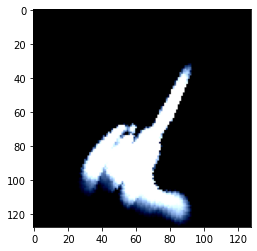

In [17]:
for img, label in train_dataloader:
    print(img.shape, label.shape)
    print(f'Ground Truth {classes_train[label[0]]}')
    plt.imshow(img[0].permute(1, 2, 0))
    break

Да уж! Мне самому трудно разобрать что это за жест.

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Взял из Resnet модель полегче, чтобы быстрее обучалась.

In [19]:
resnet = models.resnet18(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [20]:
for param in resnet.parameters():
    param.requires_grad = False

In [21]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(classes_train))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 256, 682))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 341]           9,408
       BatchNorm2d-2         [-1, 64, 128, 341]             128
              ReLU-3         [-1, 64, 128, 341]               0
         MaxPool2d-4          [-1, 64, 64, 171]               0
            Conv2d-5          [-1, 64, 64, 171]          36,864
       BatchNorm2d-6          [-1, 64, 64, 171]             128
              ReLU-7          [-1, 64, 64, 171]               0
            Conv2d-8          [-1, 64, 64, 171]          36,864
       BatchNorm2d-9          [-1, 64, 64, 171]             128
             ReLU-10          [-1, 64, 64, 171]               0
       BasicBlock-11          [-1, 64, 64, 171]               0
           Conv2d-12          [-1, 64, 64, 171]          36,864
      BatchNorm2d-13          [-1, 64, 64, 171]             128
             ReLU-14          [-1, 64, 

In [23]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Функция для обучения модели.

In [24]:
from time import time
from tqdm import tqdm


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

Обучаю классификатор модели.

In [25]:
print_every = 50
num_epoch = 12

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1]/[12]. Batch [50]/[250]. Train loss 1.644. Train acc 48.375. Val loss 1.296. Val acc 61.125. Took 79.052 seconds
Epoch [1]/[12]. Batch [100]/[250]. Train loss 1.352. Train acc 60.125. Val loss 0.844. Val acc 79.225. Took 52.133 seconds
Epoch [1]/[12]. Batch [150]/[250]. Train loss 1.156. Train acc 66.885. Val loss 0.674. Val acc 83.475. Took 53.069 seconds
Epoch [1]/[12]. Batch [200]/[250]. Train loss 1.024. Train acc 71.367. Val loss 0.578. Val acc 85.400. Took 54.470 seconds
Epoch [1]/[12]. Batch [250]/[250]. Train loss 0.930. Train acc 74.269. 

  8%|▊         | 1/12 [04:52<53:40, 292.75s/it]

Val loss 0.508. Val acc 87.350. Took 53.945 seconds
Epoch took 292.66947984695435
Epoch [2]/[12]. Batch [50]/[250]. Train loss 0.099. Train acc 83.625. Val loss 0.501. Val acc 87.275. Took 31.789 seconds
Epoch [2]/[12]. Batch [100]/[250]. Train loss 0.151. Train acc 85.625. Val loss 0.448. Val acc 88.100. Took 31.799 seconds
Epoch [2]/[12]. Batch [150]/[250]. Train loss 0.186. Train acc 86.750. Val loss 0.414. Val acc 88.650. Took 31.978 seconds
Epoch [2]/[12]. Batch [200]/[250]. Train loss 0.211. Train acc 87.430. Val loss 0.378. Val acc 90.550. Took 32.014 seconds
Epoch [2]/[12]. Batch [250]/[250]. Train loss 0.226. Train acc 88.131. 

 17%|█▋        | 2/12 [07:32<35:43, 214.40s/it]

Val loss 0.351. Val acc 90.925. Took 31.868 seconds
Epoch took 159.45324611663818
Epoch [3]/[12]. Batch [50]/[250]. Train loss 0.037. Train acc 88.125. Val loss 0.351. Val acc 90.225. Took 31.219 seconds
Epoch [3]/[12]. Batch [100]/[250]. Train loss 0.062. Train acc 89.812. Val loss 0.320. Val acc 91.975. Took 31.240 seconds
Epoch [3]/[12]. Batch [150]/[250]. Train loss 0.080. Train acc 90.750. Val loss 0.322. Val acc 91.300. Took 32.397 seconds
Epoch [3]/[12]. Batch [200]/[250]. Train loss 0.097. Train acc 90.914. Val loss 0.288. Val acc 91.975. Took 31.693 seconds
Epoch [3]/[12]. Batch [250]/[250]. Train loss 0.110. Train acc 91.094. 

 25%|██▌       | 3/12 [10:11<28:21, 189.09s/it]

Val loss 0.278. Val acc 92.550. Took 32.355 seconds
Epoch took 158.9049894809723
Epoch [4]/[12]. Batch [50]/[250]. Train loss 0.019. Train acc 91.812. Val loss 0.278. Val acc 92.725. Took 32.054 seconds
Epoch [4]/[12]. Batch [100]/[250]. Train loss 0.035. Train acc 92.188. Val loss 0.269. Val acc 93.250. Took 32.100 seconds
Epoch [4]/[12]. Batch [150]/[250]. Train loss 0.048. Train acc 92.396. Val loss 0.269. Val acc 93.200. Took 33.689 seconds
Epoch [4]/[12]. Batch [200]/[250]. Train loss 0.059. Train acc 92.594. Val loss 0.257. Val acc 93.625. Took 33.273 seconds
Epoch [4]/[12]. Batch [250]/[250]. Train loss 0.069. Train acc 92.756. 

 33%|███▎      | 4/12 [12:55<23:52, 179.10s/it]

Val loss 0.253. Val acc 93.075. Took 32.570 seconds
Epoch took 163.6867480278015
Epoch [5]/[12]. Batch [50]/[250]. Train loss 0.013. Train acc 91.969. Val loss 0.244. Val acc 93.250. Took 32.147 seconds
Epoch [5]/[12]. Batch [100]/[250]. Train loss 0.023. Train acc 92.859. Val loss 0.246. Val acc 92.875. Took 31.756 seconds
Epoch [5]/[12]. Batch [150]/[250]. Train loss 0.033. Train acc 93.062. Val loss 0.233. Val acc 93.375. Took 31.867 seconds
Epoch [5]/[12]. Batch [200]/[250]. Train loss 0.042. Train acc 93.109. Val loss 0.235. Val acc 93.550. Took 31.569 seconds
Epoch [5]/[12]. Batch [250]/[250]. Train loss 0.049. Train acc 93.213. 

 42%|████▏     | 5/12 [15:34<20:04, 172.03s/it]

Val loss 0.220. Val acc 94.025. Took 32.088 seconds
Epoch took 159.42876052856445
Epoch [6]/[12]. Batch [50]/[250]. Train loss 0.010. Train acc 92.500. Val loss 0.221. Val acc 94.025. Took 31.463 seconds
Epoch [6]/[12]. Batch [100]/[250]. Train loss 0.018. Train acc 92.750. Val loss 0.215. Val acc 94.050. Took 31.115 seconds
Epoch [6]/[12]. Batch [150]/[250]. Train loss 0.025. Train acc 93.292. Val loss 0.214. Val acc 93.900. Took 31.589 seconds
Epoch [6]/[12]. Batch [200]/[250]. Train loss 0.031. Train acc 93.438. Val loss 0.201. Val acc 94.775. Took 31.411 seconds
Epoch [6]/[12]. Batch [250]/[250]. Train loss 0.037. Train acc 93.656. 

 50%|█████     | 6/12 [18:11<16:42, 167.05s/it]

Val loss 0.194. Val acc 94.350. Took 31.715 seconds
Epoch took 157.29489088058472
Epoch [7]/[12]. Batch [50]/[250]. Train loss 0.007. Train acc 92.969. Val loss 0.203. Val acc 94.675. Took 31.817 seconds
Epoch [7]/[12]. Batch [100]/[250]. Train loss 0.013. Train acc 94.016. Val loss 0.194. Val acc 94.750. Took 31.394 seconds
Epoch [7]/[12]. Batch [150]/[250]. Train loss 0.018. Train acc 94.510. Val loss 0.194. Val acc 94.125. Took 31.596 seconds
Epoch [7]/[12]. Batch [200]/[250]. Train loss 0.023. Train acc 94.734. Val loss 0.180. Val acc 95.075. Took 31.736 seconds
Epoch [7]/[12]. Batch [250]/[250]. Train loss 0.028. Train acc 94.619. 

 58%|█████▊    | 7/12 [20:50<13:41, 164.26s/it]

Val loss 0.193. Val acc 94.575. Took 31.881 seconds
Epoch took 158.42629957199097
Epoch [8]/[12]. Batch [50]/[250]. Train loss 0.006. Train acc 93.594. Val loss 0.199. Val acc 93.950. Took 32.130 seconds
Epoch [8]/[12]. Batch [100]/[250]. Train loss 0.011. Train acc 94.000. Val loss 0.181. Val acc 94.975. Took 31.766 seconds
Epoch [8]/[12]. Batch [150]/[250]. Train loss 0.016. Train acc 94.250. Val loss 0.179. Val acc 94.825. Took 31.983 seconds
Epoch [8]/[12]. Batch [200]/[250]. Train loss 0.020. Train acc 94.438. Val loss 0.185. Val acc 94.600. Took 32.104 seconds
Epoch [8]/[12]. Batch [250]/[250]. Train loss 0.024. Train acc 94.450. 

 67%|██████▋   | 8/12 [23:30<10:51, 162.82s/it]

Val loss 0.182. Val acc 94.950. Took 31.690 seconds
Epoch took 159.6744647026062
Epoch [9]/[12]. Batch [50]/[250]. Train loss 0.005. Train acc 94.094. Val loss 0.176. Val acc 94.750. Took 31.554 seconds
Epoch [9]/[12]. Batch [100]/[250]. Train loss 0.009. Train acc 94.703. Val loss 0.175. Val acc 94.975. Took 31.577 seconds
Epoch [9]/[12]. Batch [150]/[250]. Train loss 0.013. Train acc 94.844. Val loss 0.165. Val acc 95.475. Took 31.756 seconds
Epoch [9]/[12]. Batch [200]/[250]. Train loss 0.016. Train acc 94.953. Val loss 0.165. Val acc 95.250. Took 31.384 seconds
Epoch [9]/[12]. Batch [250]/[250]. Train loss 0.020. Train acc 94.975. 

 75%|███████▌  | 9/12 [26:08<08:03, 161.28s/it]

Val loss 0.168. Val acc 95.025. Took 31.547 seconds
Epoch took 157.81868767738342
Epoch [10]/[12]. Batch [50]/[250]. Train loss 0.004. Train acc 94.062. Val loss 0.164. Val acc 95.600. Took 31.900 seconds
Epoch [10]/[12]. Batch [100]/[250]. Train loss 0.008. Train acc 94.594. Val loss 0.172. Val acc 95.000. Took 31.661 seconds
Epoch [10]/[12]. Batch [150]/[250]. Train loss 0.011. Train acc 94.833. Val loss 0.152. Val acc 95.950. Took 31.518 seconds
Epoch [10]/[12]. Batch [200]/[250]. Train loss 0.014. Train acc 95.016. Val loss 0.158. Val acc 95.400. Took 31.804 seconds
Epoch [10]/[12]. Batch [250]/[250]. Train loss 0.017. Train acc 94.975. 

 83%|████████▎ | 10/12 [28:46<05:20, 160.48s/it]

Val loss 0.156. Val acc 95.275. Took 31.677 seconds
Epoch took 158.56246209144592
Epoch [11]/[12]. Batch [50]/[250]. Train loss 0.004. Train acc 93.906. Val loss 0.149. Val acc 95.700. Took 32.126 seconds
Epoch [11]/[12]. Batch [100]/[250]. Train loss 0.007. Train acc 94.672. Val loss 0.163. Val acc 95.275. Took 32.223 seconds
Epoch [11]/[12]. Batch [150]/[250]. Train loss 0.009. Train acc 94.979. Val loss 0.163. Val acc 95.225. Took 32.113 seconds
Epoch [11]/[12]. Batch [200]/[250]. Train loss 0.012. Train acc 94.984. Val loss 0.157. Val acc 95.300. Took 32.071 seconds
Epoch [11]/[12]. Batch [250]/[250]. Train loss 0.015. Train acc 95.075. 

 92%|█████████▏| 11/12 [31:27<02:40, 160.48s/it]

Val loss 0.157. Val acc 95.225. Took 31.842 seconds
Epoch took 160.37739324569702
Epoch [12]/[12]. Batch [50]/[250]. Train loss 0.003. Train acc 94.469. Val loss 0.151. Val acc 95.325. Took 32.221 seconds
Epoch [12]/[12]. Batch [100]/[250]. Train loss 0.006. Train acc 95.031. Val loss 0.160. Val acc 94.875. Took 31.922 seconds
Epoch [12]/[12]. Batch [150]/[250]. Train loss 0.008. Train acc 95.188. Val loss 0.147. Val acc 95.775. Took 32.030 seconds
Epoch [12]/[12]. Batch [200]/[250]. Train loss 0.011. Train acc 95.250. Val loss 0.145. Val acc 95.600. Took 31.900 seconds
Epoch [12]/[12]. Batch [250]/[250]. Train loss 0.013. Train acc 95.431. 

100%|██████████| 12/12 [34:07<00:00, 170.60s/it]

Val loss 0.157. Val acc 95.550. Took 31.800 seconds
Epoch took 159.8747696876526


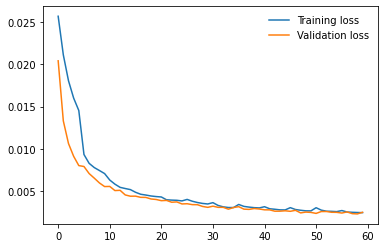

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Еще есть куда расти, но пока хватит. Последняя модель самая сильная.

In [27]:
PATH_MODEL = '/kaggle/working/best_model.pth'

In [28]:
torch.save(resnet, PATH_MODEL)

In [29]:
#model = torch.load(PATH_MODEL)

Обучаю модель на 9 слоях.

In [30]:
for param in resnet.parameters():
    param.requires_grad = True

In [31]:
cnt=0
for param in resnet.parameters():
    cnt += 1
    if cnt < 10:
        param.requires_grad = False

In [32]:
print_every = 50
num_epoch = 2

resnet1, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1]/[2]. Batch [50]/[250]. Train loss 0.173. Train acc 94.219. Val loss 0.161. Val acc 95.325. Took 33.612 seconds
Epoch [1]/[2]. Batch [100]/[250]. Train loss 0.162. Train acc 94.922. Val loss 0.159. Val acc 94.975. Took 33.560 seconds
Epoch [1]/[2]. Batch [150]/[250]. Train loss 0.161. Train acc 94.896. Val loss 0.154. Val acc 94.850. Took 33.335 seconds
Epoch [1]/[2]. Batch [200]/[250]. Train loss 0.155. Train acc 95.227. Val loss 0.150. Val acc 95.400. Took 33.909 seconds
Epoch [1]/[2]. Batch [250]/[250]. Train loss 0.153. Train acc 95.375. 

 50%|█████     | 1/2 [02:48<02:48, 168.31s/it]

Val loss 0.143. Val acc 95.625. Took 33.815 seconds
Epoch took 168.2324254512787
Epoch [2]/[2]. Batch [50]/[250]. Train loss 0.028. Train acc 95.062. Val loss 0.135. Val acc 96.175. Took 35.500 seconds
Epoch [2]/[2]. Batch [100]/[250]. Train loss 0.044. Train acc 95.312. Val loss 0.154. Val acc 94.975. Took 35.605 seconds
Epoch [2]/[2]. Batch [150]/[250]. Train loss 0.055. Train acc 95.708. Val loss 0.147. Val acc 95.575. Took 34.393 seconds
Epoch [2]/[2]. Batch [200]/[250]. Train loss 0.063. Train acc 95.797. Val loss 0.138. Val acc 95.850. Took 33.728 seconds
Epoch [2]/[2]. Batch [250]/[250]. Train loss 0.071. Train acc 95.775. 

100%|██████████| 2/2 [05:41<00:00, 170.57s/it]

Val loss 0.135. Val acc 95.950. Took 33.523 seconds
Epoch took 172.75016903877258


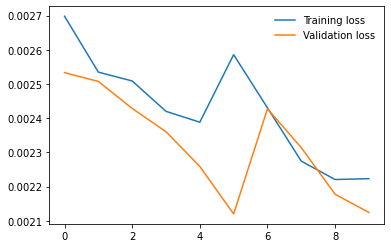

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Дальнейшее обучение уменьшило метрику.

In [34]:
PATH_MODEL2 = '/kaggle/working/best_model2.pth'

In [35]:
torch.save(resnet1, PATH_MODEL2)

In [36]:
#resnet1 = torch.load(PATH_MODEL, map_location=torch.device('cpu'))

In [42]:
resnet1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  



Инференс

In [38]:
test_data_path = '../input/leapgestrecog/leapgestrecog/leapGestRecog/07/'

In [39]:
%%time
test_dataset = datasets.ImageFolder(test_data_path, transform=val_transforms)

CPU times: user 9.89 ms, sys: 99 µs, total: 9.99 ms
Wall time: 17.9 ms


In [40]:
len(test_dataset)

2000

IndexError: index 6 is out of bounds for axis 0 with size 6

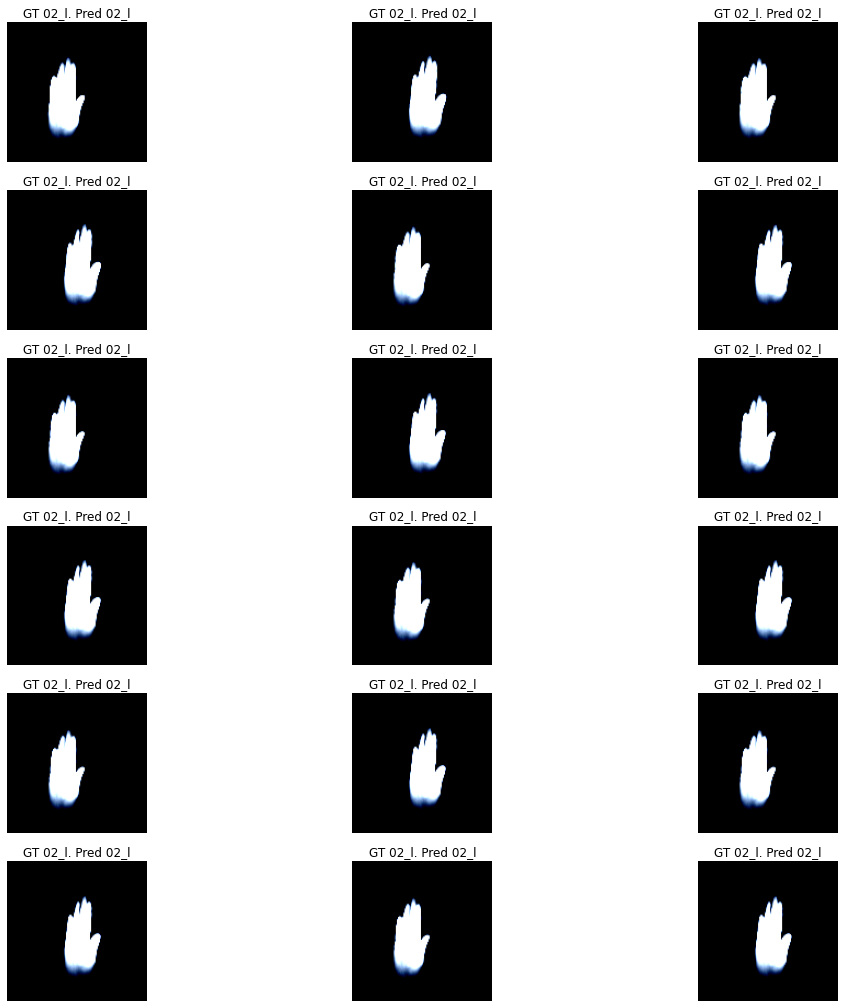

In [41]:
columns = 3
#row = round(len(test_dataset) / columns)
row=6

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
for img, labels in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet1(img[None])

    ax[i][j].imshow(img.cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {classes_train[labels]}. Pred {classes_train[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1
        
plt.show()

Жесты в датасете не перемешаны, поэтому одинаковые.

In [43]:
import seaborn

Text(0.5, 68.09375, 'Predicted label')

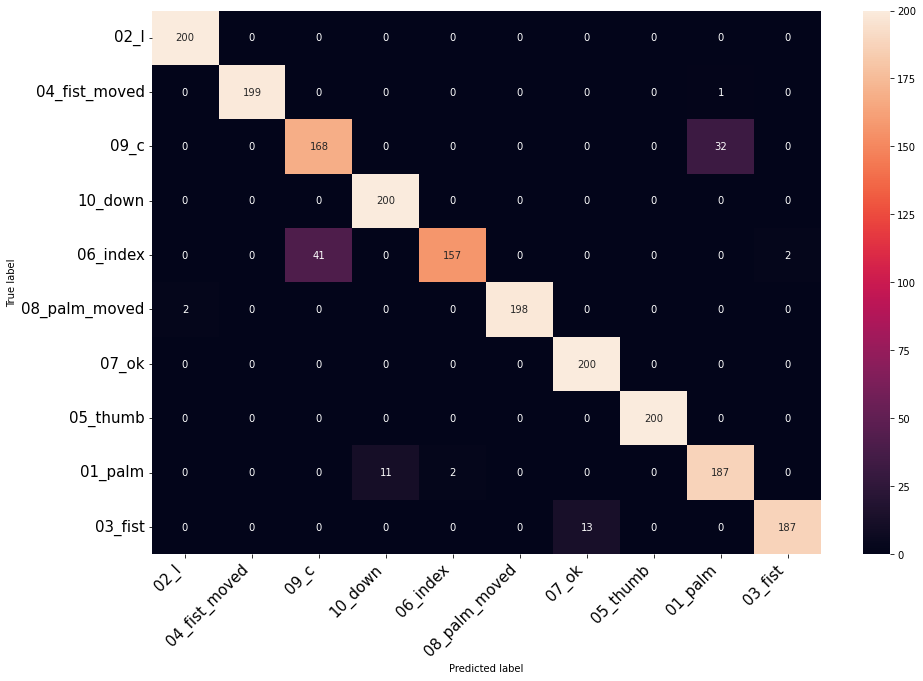

In [44]:
confusion_matrix = torch.zeros(len(classes_train), len(classes_train))

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataset):
        inputs = inputs.to(device)
        classes = torch.tensor(classes)
        classes = classes.to(device)
        outputs = resnet1(inputs.reshape(1, 3, 128, 128))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = classes_train
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

Видимо путает жесты при рандомном их повороте на 30 градусов, как я задал в аугментации. В аугментации градус наклона надо подправить.

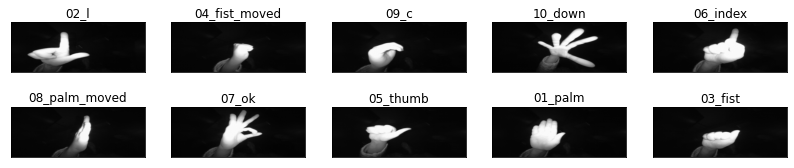

In [45]:
dir = '../input/leapgestrecog/leapGestRecog'
folders = os.listdir(dir)
folder_person = [dir + '/' + folder for folder in folders][0]
folder_gesture = [folder_person + "/" + gesture for gesture in os.listdir(folder_person)]
gestures = [gesture for gesture in os.listdir(folder_person)]

all_images = []
for i in range(len(folder_gesture)):
    all_images.append(os.listdir(folder_gesture[i])[0])
    
images = []
for i in range(len(folder_gesture)):
    images.append(folder_gesture[i] + "/" + all_images[i])
        
images = np.array([cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images])
names = [name for name in gestures]
plot_portraits(images, names, 256, 256, n_row=2, n_col=5)

In [46]:
dir = '/kaggle/input/gestures'
folder = os.listdir(dir)
#folder_person = [dir + '/' + folder for folder in folders][0]
#folder_gesture = [folder_person + "/" + gesture for gesture in os.listdir(folder_person)]
#gestures = [gesture for gesture in os.listdir(folder_person)]

all_images = []
for i in range(len(folder)):
    all_images.append(folder[i])   
#images = []
#for i in range(len(folder_gesture)):
 #   images.append(folder_gesture[i] + "/" + all_images[i])
        
images = np.array([cv2.imread(dir + "/" + image, cv2.IMREAD_GRAYSCALE) for image in all_images])
#names = [name for name in gestures]
plot_portraits(images, all_images, 128, 128, n_row=9, n_col=4)

['frame_07_02_0067.png',
 'frame_07_04_0162.png',
 'frame_07_09_0131.png',
 'frame_07_10_0124.png',
 'frame_07_06_0198.png',
 'frame_07_08_0074.png',
 'frame_07_07_0074.png',
 'frame_07_05_0183.png',
 'frame_07_01_0175.png',
 'frame_07_03_0034.png']

In [47]:
def print_gesture(path_to_image, model):
    frame = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame,(128, 128))
    cv2.imwrite('gray.jpg', frame)
    frame = cv2.imread('gray.jpg')
    plt.imshow(frame)

    
    torch_frame = torch.from_numpy(frame).permute(2, 0, 1).to(device).float()
    gesture = model(torch_frame[None, ...])  
    gesture = classes_train[gesture.argmax()]
    print(f"Predict: {gesture}")

Predict: 02_l


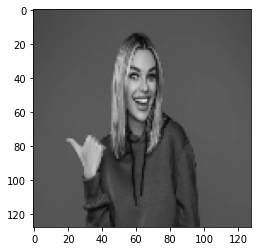

In [48]:
print_gesture('/kaggle/input/gestures/18.jpg', resnet1)

На всех картинках из Интернета предсказание 02_l. И хотя в картинках из интернета мало жестов, близких к обученным, из этого следует, что жесты надо вырезать.

In [ ]:
++++++

# Часть 2.
Пишу скрипт, в котором построю пайплайн распознавания найденного лица с изображения а затем распознавания жеста.

In [49]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.9 MB/s eta 0:00:0000:0100:010m


In [50]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
PATH_MODEL = '/kaggle/input/best-model-gesture/best_model2.pth'

In [55]:
model = torch.load(PATH_MODEL, map_location=torch.device('cpu'))

In [58]:
class FaceDetector(object):
    """ Класс для считывания фото. При наличии на фото лица, определяет какой
    жест этот человек делает поднятой правой рукой. """   
    def __init__(self, mtcnn, model, channels=1):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = model
        self.emodel.eval()
        self.classes_train = ['02_l', '04_fist_moved', '09_c', '10_down', 
                              '06_index', '08_palm_moved', '07_ok', 
                              '05_thumb', '01_palm', '03_fist']
        self.channels = channels    
        
    @staticmethod
    def crop_hand(frame, boxes):
        """ Функция для вырезания кадра с жестом на фото """
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
        
        
        
    def run(self, path_to_img):
        """
        Функция для запуска FaceDetector и определения жеста человека.
        """                
        frame = cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite('gray.jpg', frame)
        frame = cv2.imread('gray.jpg')
        print("Загруженное изображение:")
        plt.imshow(frame)
        
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

        if max(probs) > 0.7:
            hand_crop = self.crop_hand(frame, [[0, 0, 250, 350]])[0]
            hand_img = cv2.resize(hand_crop,(128,128))
            plt.imshow(hand_img)
            # Генерация тензора
            torch_frame = torch.from_numpy(hand_img).permute(2, 0, 1).to(self.device).float()
            # Предсказание
            gesture = self.emodel(torch_frame[None, ...])
            gesture = self.classes_train[gesture.argmax()]
            
            print(f"Предсказанный жест: {gesture}")  
                      

In [59]:
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn, model)

Загруженное изображение:
Предсказанный жест: 08_palm_moved


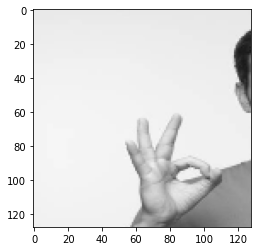

In [60]:
fcd.run('/kaggle/input/gestures/10.jpg')

Загруженное изображение:
Предсказанный жест: 04_fist_moved


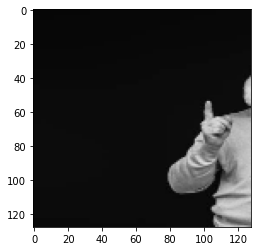

In [61]:
fcd.run('/kaggle/input/gestures/13.jpg')

Загруженное изображение:
Предсказанный жест: 02_l


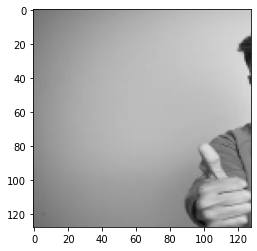

In [62]:
fcd.run('/kaggle/input/gestures/14.jpg')

Загруженное изображение:
Предсказанный жест: 08_palm_moved


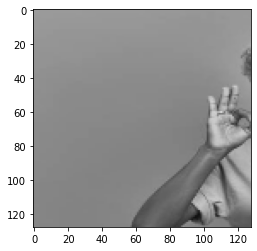

In [63]:
fcd.run('/kaggle/input/gestures/17.jpg')

Загруженное изображение:
Предсказанный жест: 02_l


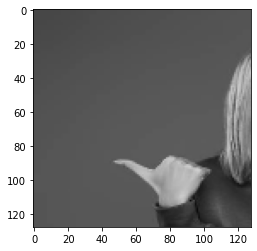

In [64]:
fcd.run('/kaggle/input/gestures/18.jpg')

Загруженное изображение:
Предсказанный жест: 09_c


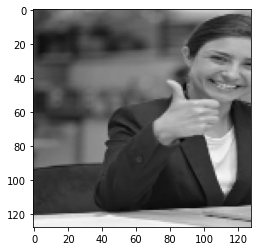

In [65]:
fcd.run('/kaggle/input/gestures/25.jpg')

Загруженное изображение:
Предсказанный жест: 07_ok


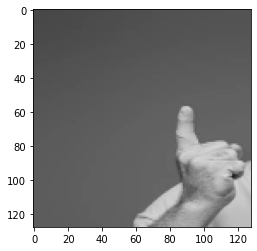

In [66]:
fcd.run('/kaggle/input/gestures/26.jpg')

Загруженное изображение:
Предсказанный жест: 07_ok


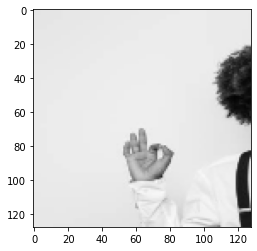

In [67]:
fcd.run('/kaggle/input/gestures/27.jpg')

Загруженное изображение:
Предсказанный жест: 05_thumb


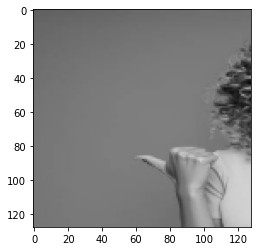

In [68]:
fcd.run('/kaggle/input/gestures/6.jpg')

Загруженное изображение:
Предсказанный жест: 09_c


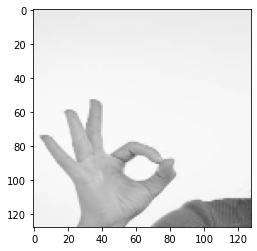

In [69]:
fcd.run('/kaggle/input/gestures/8.jpg')

Загруженное изображение:
Предсказанный жест: 04_fist_moved


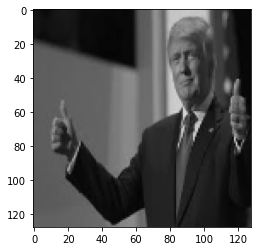

In [71]:
fcd.run('/kaggle/input/gestures/images.jpg')

Не смотря на высокую метрику качества, с загугленных картинок жесты предсказывает плохо.